In [14]:
from data_utils import *
from model_utils import *
from train_utils import *
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load dataset
classes = get_classes()
dataset = load_and_preprocess_dataset(HAND_LANDMARKS_CSV)
train_dataset, val_dataset = split_dataset(dataset, val_ratio=0.2, random_seed=42)
train_loader, val_loader = get_loaders(train_dataset, val_dataset, batch_size=32)

print(f"Aantal classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Aantal classes: 35
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Training samples: 1567
Validation samples: 391


In [16]:
in_dim = 63  # 21 landmarks * 3 coordinates
num_classes = len(classes)
model = create_model(num_classes, in_dim)
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'asl_alphabet_model.pth'), map_location=DEVICE))

<All keys matched successfully>

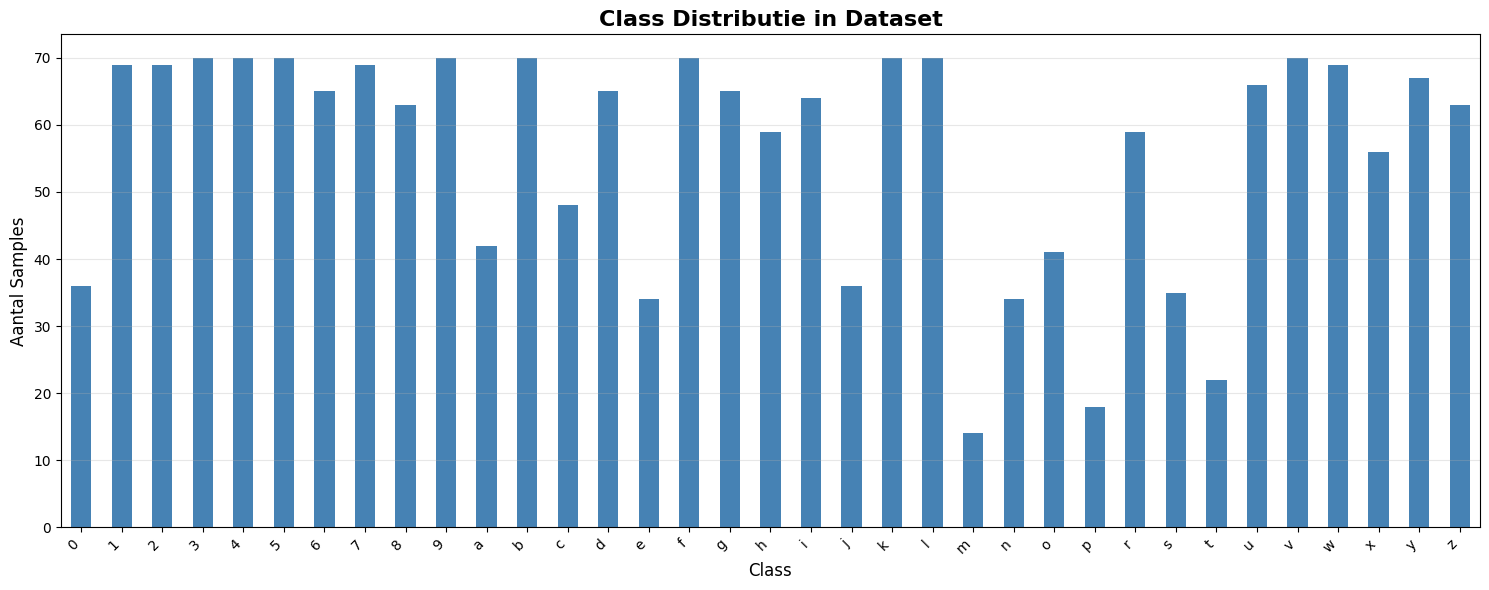


Totaal aantal samples: 1958
Gemiddeld aantal samples per class: 55.9
Min samples: 14, Max samples: 70


In [17]:
df = pd.read_csv(HAND_LANDMARKS_CSV)
class_counts = df['class'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Class Distributie in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Aantal Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotaal aantal samples: {len(df)}")
print(f"Gemiddeld aantal samples per class: {class_counts.mean():.1f}")
print(f"Min samples: {class_counts.min()}, Max samples: {class_counts.max()}")

In [18]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs.view(inputs.size(0), -1))
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Bereken accuracy
accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 86.45%


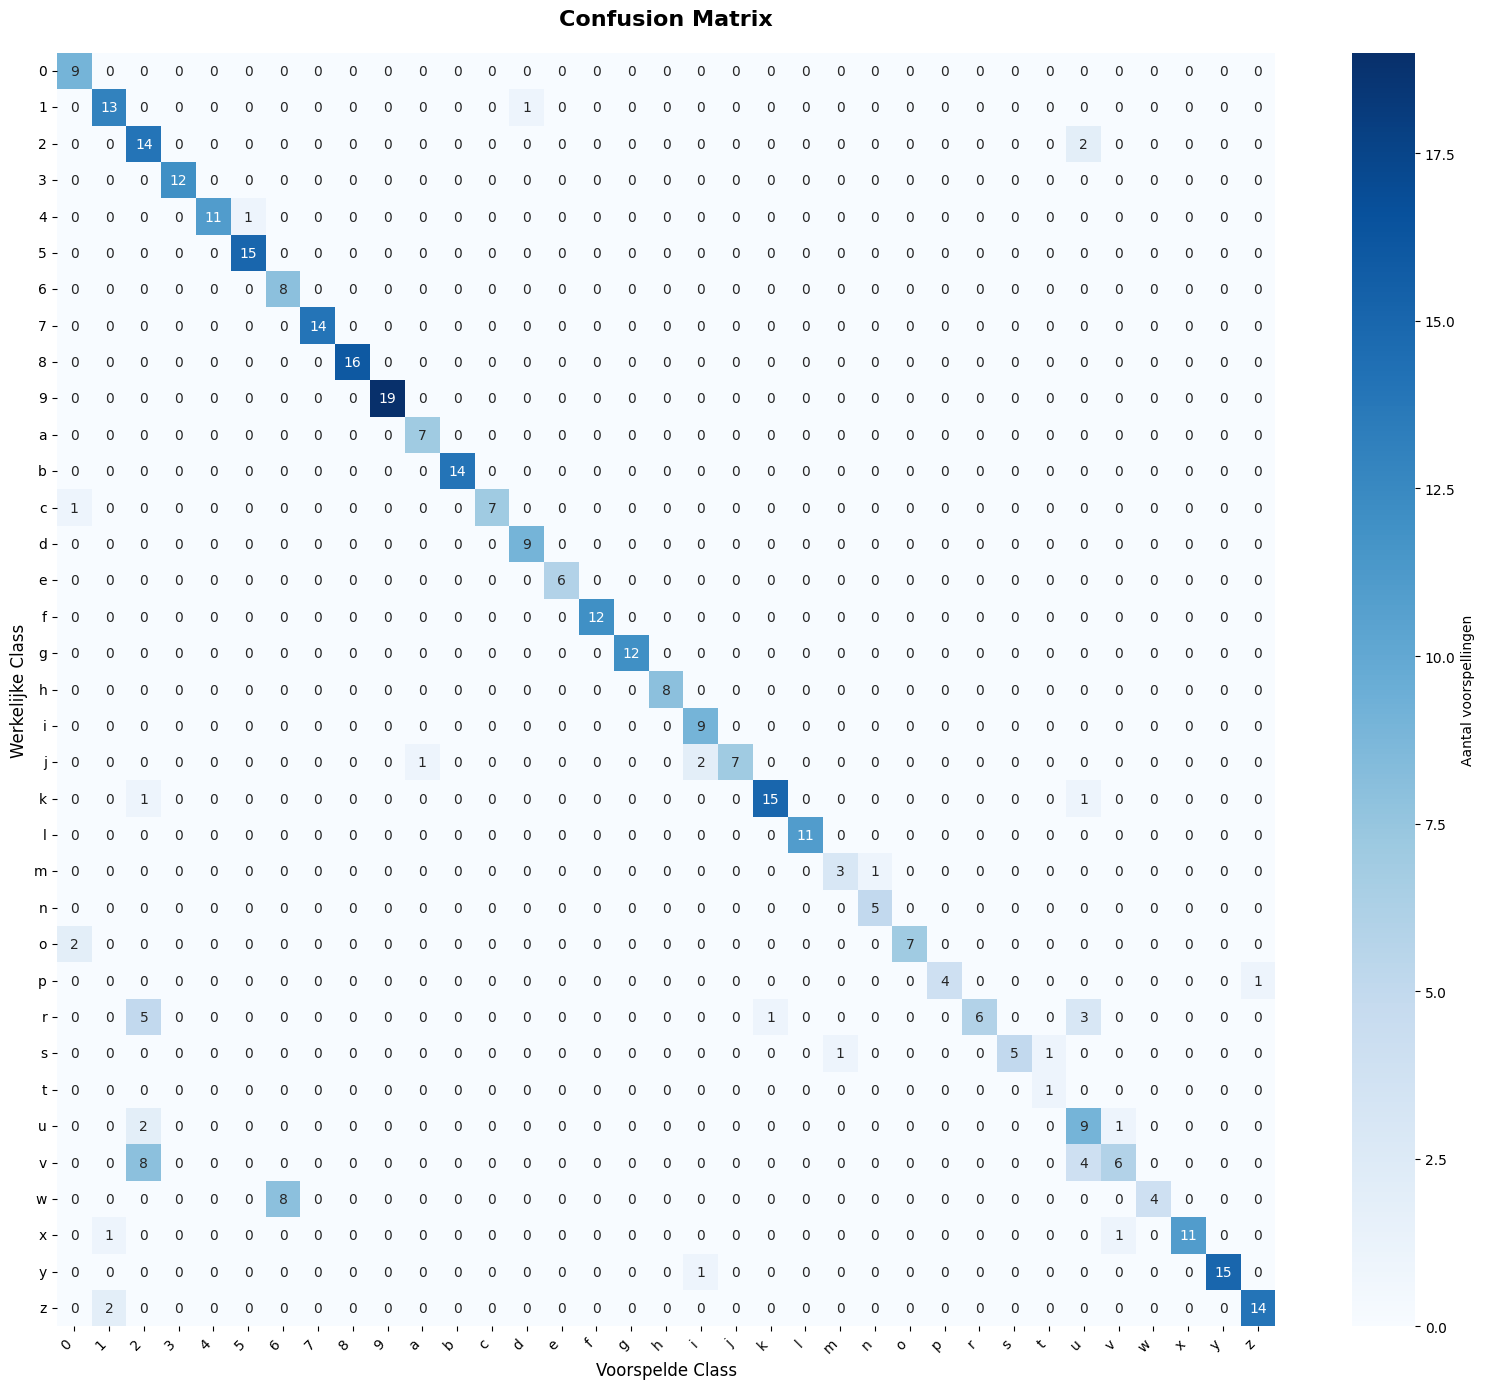

In [19]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Aantal voorspellingen'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Werkelijke Class', fontsize=12)
plt.xlabel('Voorspelde Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_labels, all_preds, target_names=classes, digits=3))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0      0.750     1.000     0.857         9
           1      0.812     0.929     0.867        14
           2      0.467     0.875     0.609        16
           3      1.000     1.000     1.000        12
           4      1.000     0.917     0.957        12
           5      0.938     1.000     0.968        15
           6      0.500     1.000     0.667         8
           7      1.000     1.000     1.000        14
           8      1.000     1.000     1.000        16
           9      1.000     1.000     1.000        19
           a      0.875     1.000     0.933         7
           b      1.000     1.000     1.000        14
           c      1.000     0.875     0.933         8
           d      0.900     1.000     0.947         9
           e      1.000     1.000     1.000         6
           f      1.000     1.000     1.000        12
           g      1.000     1.000     1.000        12
    

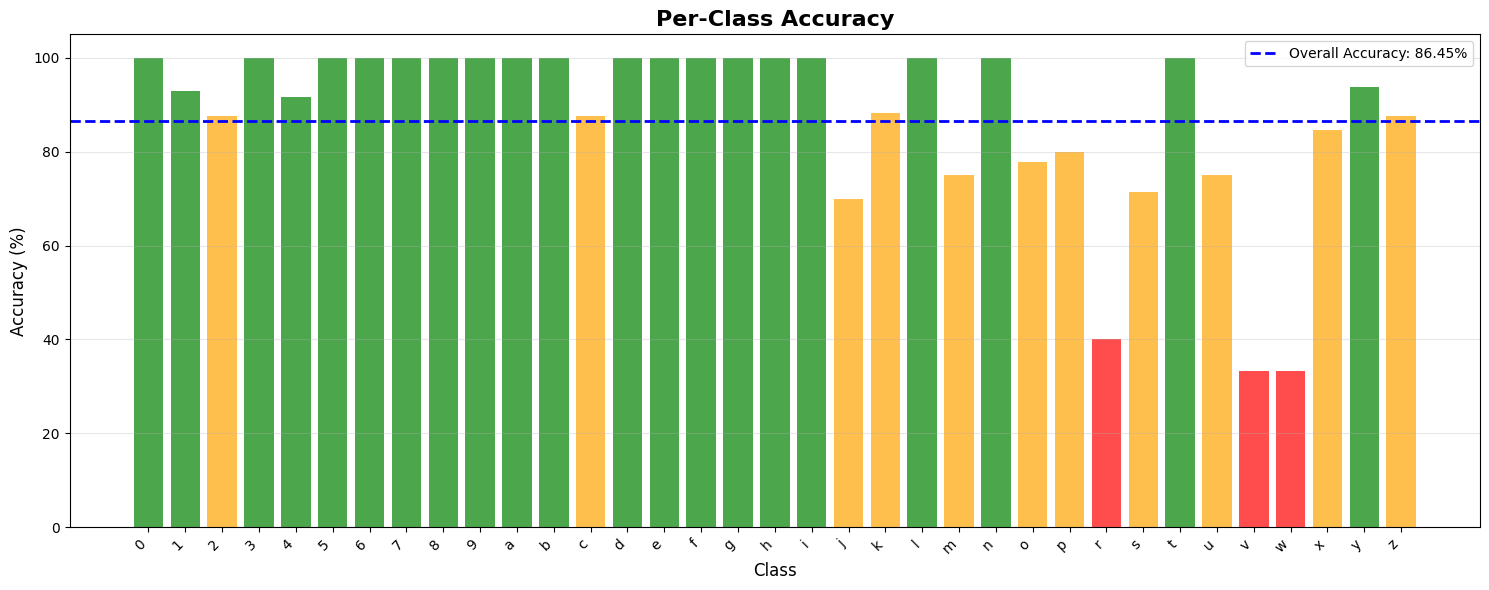


Classes met laagste accuracy:
  v: 33.33%
  w: 33.33%
  r: 40.00%
  j: 70.00%
  s: 71.43%


In [21]:
# Bereken per-class accuracy
per_class_accuracy = []
for i in range(len(classes)):
    mask = all_labels == i
    if mask.sum() > 0:
        acc = 100 * (all_preds[mask] == all_labels[mask]).sum() / mask.sum()
        per_class_accuracy.append(acc)
    else:
        per_class_accuracy.append(0)

# Plot per-class accuracy
plt.figure(figsize=(15, 6))
colors = ['green' if acc >= 90 else 'orange' if acc >= 70 else 'red' for acc in per_class_accuracy]
plt.bar(classes, per_class_accuracy, color=colors, alpha=0.7)
plt.axhline(y=accuracy, color='blue', linestyle='--', label=f'Overall Accuracy: {accuracy:.2f}%', linewidth=2)
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print classes met laagste accuracy
print("\nClasses met laagste accuracy:")
sorted_indices = np.argsort(per_class_accuracy)[:5]
for idx in sorted_indices:
    print(f"  {classes[idx]}: {per_class_accuracy[idx]:.2f}%")

/tmp/ipykernel_83557/1467936303.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_confidences, incorrect_confidences], labels=['Correct', 'Incorrect'])


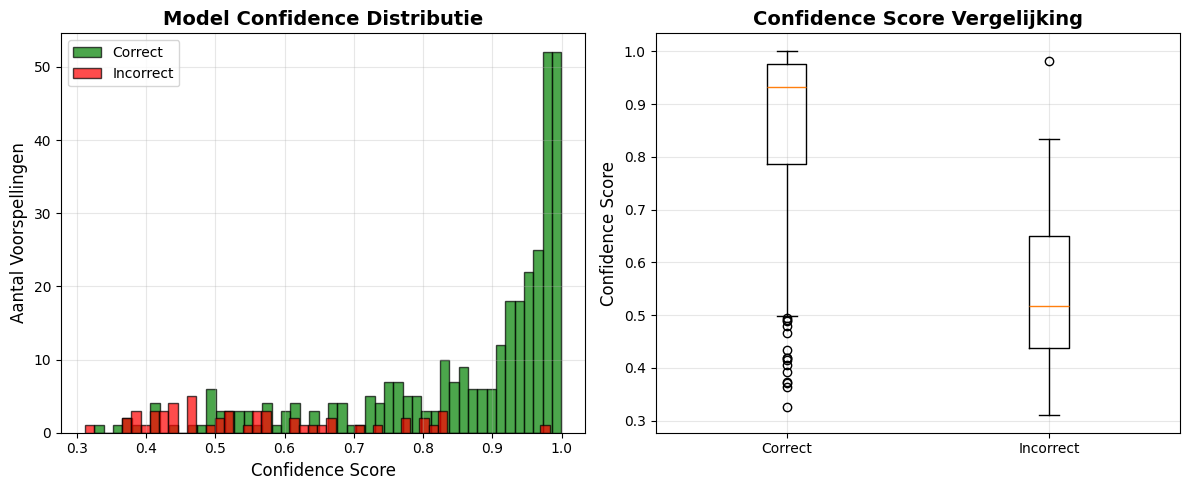


Gemiddelde confidence (correct): 0.8599
Gemiddelde confidence (incorrect): 0.5592


In [22]:
# Bereken confidence scores
all_confidences = []
correct_confidences = []
incorrect_confidences = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs.view(inputs.size(0), -1))
        probs = torch.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probs, 1)
        
        for conf, pred, label in zip(confidences.cpu().numpy(), 
                                     predicted.cpu().numpy(), 
                                     labels.cpu().numpy()):
            all_confidences.append(conf)
            if pred == label:
                correct_confidences.append(conf)
            else:
                incorrect_confidences.append(conf)

# Plot confidence distributie
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
plt.hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Aantal Voorspellingen', fontsize=12)
plt.title('Model Confidence Distributie', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([correct_confidences, incorrect_confidences], labels=['Correct', 'Incorrect'])
plt.ylabel('Confidence Score', fontsize=12)
plt.title('Confidence Score Vergelijking', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGemiddelde confidence (correct): {np.mean(correct_confidences):.4f}")
print(f"Gemiddelde confidence (incorrect): {np.mean(incorrect_confidences):.4f}")

In [23]:
# Print model architecture
print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotaal aantal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Input dimensie: {in_dim}")
print(f"Output classes: {num_classes}")
print(f"Device: {DEVICE}")


MODEL ARCHITECTURE
Sequential(
  (0): Linear(in_features=63, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=256, out_features=35, bias=True)
)

Totaal aantal parameters: 91,171
Trainable parameters: 91,171
Input dimensie: 63
Output classes: 35
Device: cpu
